In [1]:
import os
#os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from support.pyDeepInsight import ImageTransformer
from support.pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np


Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [2]:
expr_file = r"./data/Li/data.csv"
expr = pd.read_csv(expr_file, sep=",")
y = expr.iloc[:, 0].values
X = expr.iloc[:, 1:].values
df = pd.DataFrame(y, columns=['info'])
df['value'] = df['info'].str.split(':').str[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, df['value'], test_size=0.2, stratify=df['value'])
print(np.unique(df['value'], return_counts=True))

(array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrM', 'chrX', 'chrY'], dtype=object), array([5297, 2226, 3182, 2788, 1200, 2233, 2067, 2311, 2884, 1114, 2895,
       4004, 1302,  730, 1257, 3072, 2539, 2833, 2879, 2852, 2356, 2303,
         13, 2370,  534], dtype=int64))


In [3]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

In [4]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

In [5]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification\support\pyDeepInsight\image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


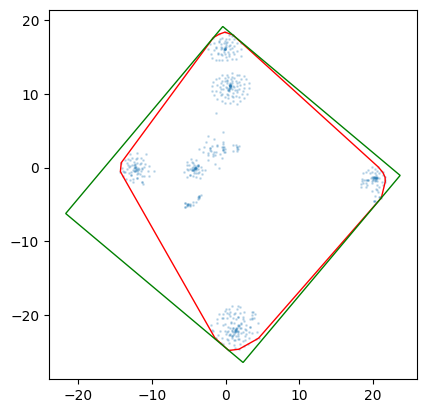

MemoryError: Unable to allocate 52.7 GiB for an array with shape (45792, 227, 227, 3) and data type float64

In [6]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

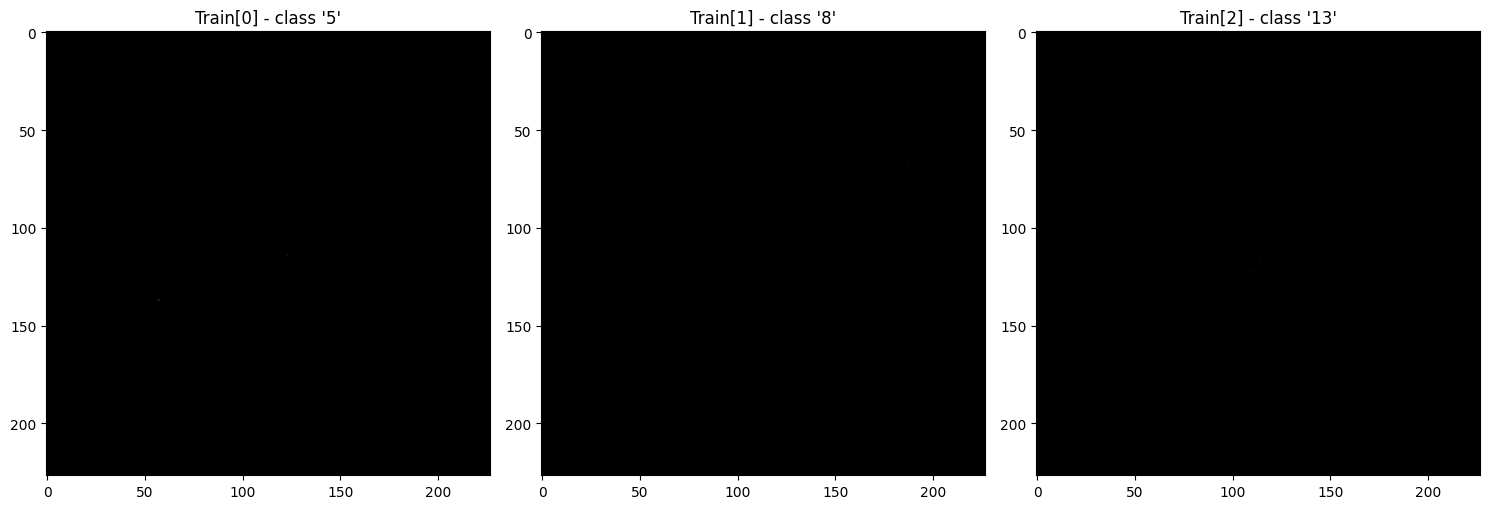

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train_enc[i]}'")
plt.tight_layout()

In [ ]:

X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(le.transform(y_test))

In [ ]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

In [ ]:
model.train()
model.to(device)
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

In [ ]:
model.to('cpu')
model = model.eval()

In [ ]:
with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

In [ ]:
with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]

In [ ]:
import torch.nn.functional as F
probs_test = F.softmax(y_hat, dim=1).numpy()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Calculate precision with 'macro' average
precision_macro = precision_score(test_predicted, y_test_tensor, average='macro')

# Calculate precision with 'micro' average
precision_micro = precision_score(test_predicted, y_test_tensor, average='micro')

# Calculate precision with 'weighted' average
precision_weighted = precision_score(test_predicted, y_test_tensor, average='weighted')

# Calculate recall with 'macro' average
recall_macro = recall_score(test_predicted, y_test_tensor, average='macro')

# Calculate recall with 'micro' average
recall_micro = recall_score(test_predicted, y_test_tensor, average='micro')

# Calculate recall with 'weighted' average
recall_weighted = recall_score(test_predicted, y_test_tensor, average='weighted')

# Calculate F1-score with 'macro' average
f1_macro = f1_score(test_predicted, y_test_tensor, average='macro')

# Calculate F1-score with 'micro' average
f1_micro = f1_score(test_predicted, y_test_tensor, average='micro')

# Calculate F1-score with 'weighted' average
f1_weighted = f1_score(test_predicted, y_test_tensor, average='weighted')

# Calculate ROC-AUC score with One-vs-One (OvO) strategy
roc_auc_ovo_macro = roc_auc_score(y_test_tensor, probs_test, multi_class='ovo', average='macro')
roc_auc_ovo_weighted = roc_auc_score(y_test_tensor, probs_test, multi_class='ovo', average='weighted')

# Calculate ROC-AUC score with One-vs-Rest (OvR) strategy
roc_auc_ovr_macro = roc_auc_score(y_test_tensor, probs_test, multi_class='ovr', average='macro')
roc_auc_ovr_weighted = roc_auc_score(y_test_tensor, probs_test, multi_class='ovr', average='weighted')

# Classification report (includes precision, recall, F1-score, support)
report = classification_report(test_predicted, y_test_tensor)

train_accuracy = accuracy_score(train_predicted, y_train_tensor)


# Calculate test accuracy
test_accuracy = accuracy_score(test_predicted, y_test_tensor )
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_ovo_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_ovo_weighted)
print("ROC-AUC (OvR, Macro):", roc_auc_ovr_macro)
print("ROC-AUC (OvR, Weighted):", roc_auc_ovr_weighted)
print("\nClassification Report:")
print(report)
disp = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=le.classes_)